In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv('ebay_mens_perfume.csv')

In [12]:
df.head()

,brand,title,type,price,priceWithCurrency,available,availableText,sold,lastUpdated,itemLocation
0,Dior,Christian Dior Sauvage Men's EDP 3.4 oz Fragra...,Eau de Parfum,84.99,US $84.99/ea,10.0,More than 10 available / 116 sold,116.0,"May 24, 2024 10:03:04 PDT","Allen Park, Michigan, United States"
1,AS SHOW,A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...,Eau de Parfum,109.99,US $109.99,8.0,8 available / 48 sold,48.0,"May 23, 2024 23:07:49 PDT","Atlanta, Georgia, Canada"
2,Unbranded,HOGO BOSS cologne For Men 3.4 oz,Eau de Toilette,100.00,US $100.00,10.0,More than 10 available / 27 sold,27.0,"May 22, 2024 21:55:43 PDT","Dearborn, Michigan, United States"
3,Giorgio Armani,Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...,Eau de Toilette,44.99,US $44.99/ea,2.0,2 available / 159 sold,159.0,"May 24, 2024 03:30:43 PDT","Reinholds, Pennsylvania, United States"
4,Lattafa,Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...,Fragrances,16.91,US $16.91,NaN,Limited quantity available / 156 sold,156.0,"May 24, 2024 07:56:25 PDT","Brooklyn, New York, United States"


In [13]:
print(df.isnull().sum())

# Data Cleaning & Imputation
# For 'brand', impute missing values with the most frequent value
df['brand'].fillna(df['brand'].mode()[0], inplace=True)

# For 'type', impute missing values with the most frequent value (mode)
df['type'].fillna(df['type'].mode()[0], inplace=True)

# For 'available', use the median to impute missing values
df['available'].fillna(df['available'].median(), inplace=True)

# For 'sold', use the median to impute missing values
df['sold'].fillna(df['sold'].median(), inplace=True)

# Drop rows with missing 'lastUpdated'
df.dropna(subset=['lastUpdated'], inplace=True)



brand                  1
title                  0
type                   3
price                  0
priceWithCurrency      0
available            111
availableText          3
sold                   6
lastUpdated           53
itemLocation           0
dtype: int64


In [14]:
# Verify that there are no missing values left
print(df.isnull().sum())

brand                0
title                0
type                 0
price                0
priceWithCurrency    0
available            0
availableText        0
sold                 0
lastUpdated          0
itemLocation         0
dtype: int64


In [15]:
conn = sqlite3.connect('perfume_data.db')

# Upload the DataFrame to SQLite
df.to_sql('perfume_data', conn, if_exists='replace', index=False)

# Verify data upload by querying the first few rows
cursor = conn.cursor()
cursor.execute('SELECT * FROM perfume_data LIMIT 3')
rows = cursor.fetchall()

# Display the first 3 rows to ensure data was uploaded
for row in rows:
    print(row)
    print(" ")

('Dior', "Christian Dior Sauvage Men's EDP 3.4 oz Fragrance Spray", 'Eau de Parfum', 84.99, 'US $84.99/ea', 10.0, 'More than 10 available / 116 sold', 116.0, 'May 24, 2024 10:03:04 PDT', 'Allen Park, Michigan, United States')
 
('AS SHOW', 'A-v-entus Eau de Parfum 3.3 oz 100ML Millesime EDP Col-ogne for Men New In Box', 'Eau de Parfum', 109.99, 'US $109.99', 8.0, '8 available / 48 sold', 48.0, 'May 23, 2024 23:07:49 PDT', 'Atlanta, Georgia, Canada')
 
('Unbranded', 'HOGO BOSS cologne For Men 3.4 oz', 'Eau de Toilette', 100.0, 'US $100.00', 10.0, 'More than 10 available / 27 sold', 27.0, 'May 22, 2024 21:55:43 PDT', 'Dearborn, Michigan, United States')
 


In [16]:
# Query to find the price range with the maximum sales
query = '''
SELECT price, SUM(sold) AS total_sold
FROM perfume_data
GROUP BY price
ORDER BY total_sold DESC
'''
result = pd.read_sql_query(query, conn)
print(result)

     price  total_sold
0    23.89     54066.0
1    25.23     40130.0
2    39.77     31718.0
3    46.33     30655.0
4    23.56     24048.0
..     ...         ...
568  91.00         1.0
569  74.59         1.0
570  55.00         1.0
571  45.35         1.0
572  15.39         1.0

[573 rows x 2 columns]


In [21]:
# Create discrete price bins for analysis by categorizing prices into specific ranges
price_bins = pd.cut(df['price'], bins=[0, 20, 40, 60, 80, 100, 200, 500, 10000], labels=['0-20', '20-40', '40-60', '60-80', '80-100', '100-200', '200-500', '500+'])

# Add the bins to the data
df['price_bin'] = price_bins

# Analyze total sales in each price bin
sales_by_bin = df.groupby('price_bin')['sold'].sum().reset_index()

# Display the sales by price bin
print(sales_by_bin)


  price_bin      sold
0      0-20  125336.0
1     20-40  440880.0
2     40-60  143742.0
3     60-80   30786.0
4    80-100   14240.0
5   100-200    5782.0
6   200-500     541.0
7      500+       0.0


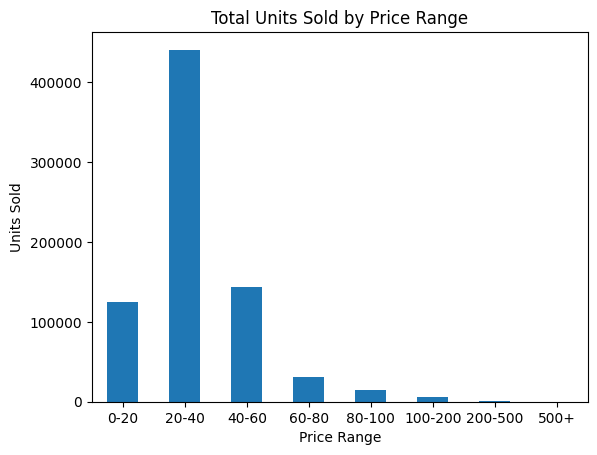

In [22]:
sales_by_bin.plot(kind='bar', x='price_bin', y='sold', legend=False)
plt.title('Total Units Sold by Price Range')
plt.ylabel('Units Sold')
plt.xlabel('Price Range')
plt.xticks(rotation=0)
plt.show()


              price  available      sold
price      1.000000  -0.100248 -0.088545
available -0.100248   1.000000  0.102191
sold      -0.088545   0.102191  1.000000


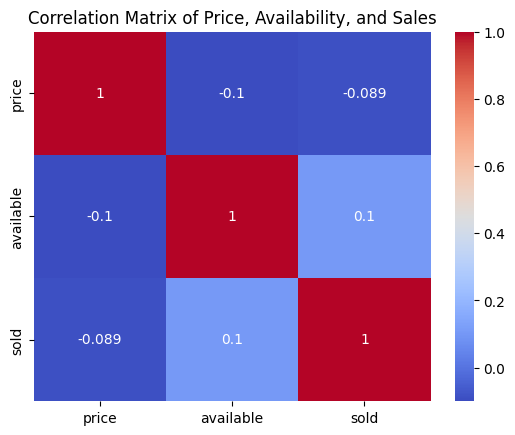

In [24]:
# Correlation between price, available, and sold
corr_matrix = df[['price', 'available', 'sold']].corr()
print(corr_matrix)

# Heatmap for correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Price, Availability, and Sales')
plt.show()

In [27]:
# Hypothesis Test: Does price significantly affect sales?
import scipy.stats as stats
correlation, p_value = stats.pearsonr(df['price'], df['sold'])
print(f'Correlation: {correlation}, P-value: {p_value}')

if p_value < 0.05:
    print("Reject the null hypothesis: Price significantly affects sales.")
else:
    print("Fail to reject the null hypothesis: Price does not significantly affect sales.")

Correlation: -0.08854510263430072, P-value: 0.006399270325415289
Reject the null hypothesis: Price significantly affects sales.


In [23]:
# Additional Analysis: Total Sales by Brand

# Query for total sales by brand
query_brand_sales = 
'''
SELECT brand, SUM(sold) AS total_sold
FROM perfume_data
GROUP BY brand
ORDER BY total_sold DESC
'''
brand_sales = pd.read_sql_query(query_brand_sales, conn)
print(brand_sales.head())

          brand  total_sold
0  Calvin Klein     97564.0
1       Versace     96519.0
2      Davidoff     54944.0
3        Azzaro     38301.0
4         Armaf     24276.0
